# Сравнение моделей для извлечения сущностей из юридических контрактов

**Цель:**
- Извлекать структурированную информацию (сущности, события и отношения) из текстов с помощью методов NER и Information Extraction.
- Применить локально развернутые языковые модели для решения реальных задач (юридические, медицинские, новостные данные), оптимизировать производительность моделей и разработать простое приложение, демонстрирующее извлечение данных.

**Трек A:** Извлечение из юридических документов.

**Датасет:**

- https://huggingface.co/datasets/hugsid/legal-contracts - 38,000 контрактов разных типов (можно взять 500-1K примеров).

**Извлекаемые сущности:** PERSON, ORG, MONEY, DATE, CONTRACT_TYPE, OBLIGATION, JURISDICTION.



In [1]:
%%capture
install = True
if install:
  !pip install transformers accelerate bitsandbytes tdqm


In [2]:
# Оптимизация для Colab
import os
# Установка переменных окружения для стабильности
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [3]:
import torch
import psutil
import pynvml
import time
import json
import re
import pandas as pd
import hashlib
from functools import lru_cache

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig
from datasets import load_dataset

import matplotlib.pyplot as plt

## Загрузка датасета + подвыборка 500 документов

In [4]:
from datasets import load_dataset

ds = load_dataset("hugsid/legal-contracts", split="train[:500]")

texts = [item['text'] for item in ds]

print(f"Загружено {len(texts)} документов для тестирования")
print(f"Пример документа (первые 150 символов):\n{texts[0][:150]}...\n")

Загружено 500 документов для тестирования
Пример документа (первые 150 символов):
THIS SUPPLEMENT AND JOINDER AGREEMENT (this Agreement), dated as of September 29, 2017, is made among Triangle Capital Corporation, a Maryland corpora...



### Шаблон промпта для извлечения сущностей

In [5]:
ENTITY_EXTRACTION_PROMPT = """You are a legal expert specializing in contract analysis. Extract entities from the contract text below.

REQUIRED ENTITIES:
- PERSON: Full names of individuals (e.g., "John Smith, CEO")
- ORG: Full legal names of organizations/companies
- MONEY: Monetary amounts with currency (e.g., "$5,000,000", "€2.5M")
- DATE: All dates in any format (e.g., "September 29, 2017", "05/04/2015")
- CONTRACT_TYPE: Type of agreement (e.g., "Credit Agreement", "Joinder Agreement")
- OBLIGATION: Key obligations/covenants (max 5, concise phrases ≤15 words each)
- JURISDICTION: Governing law jurisdiction (e.g., "State of New York")

RULES:
- Return ONLY valid JSON with exact schema below
- Lists (PERSON, ORG, MONEY, DATE, OBLIGATION): empty array [] if none found
- Single values (CONTRACT_TYPE, JURISDICTION): empty string "" if not found
- DO NOT invent entities not present in text
- DO NOT include any text before/after JSON

OUTPUT SCHEMA (STRICT):
{{
  "PERSON": ["string"],
  "ORG": ["string"],
  "MONEY": ["string"],
  "DATE": ["string"],
  "CONTRACT_TYPE": "string",
  "OBLIGATION": ["string"],
  "JURISDICTION": "string"
}}

Contract text:
{text}"""

## Вспомогалтельные функции для мониторинга

In [6]:
# Отключаем параллелизм токенизатора для стабильности
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Инициализация мониторинга GPU
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_gpu_memory():
    """Получение использования VRAM в МБ"""
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used / 1024**2

def get_ram_usage():
    """Получение использования RAM в МБ"""
    return psutil.Process().memory_info().rss / 1024**2

def cleanup():
    """Очистка памяти"""
    torch.cuda.empty_cache()
    import gc
    gc.collect()

## Загрузка моделей и тестирование

In [7]:
class ModelEvaluator:
    def __init__(self, model_name, quantization=None, max_new_tokens=100):
        """
        Инициализация эвалюатора модели.

        Args:
            model_name: имя модели на Hugging Face Hub
            quantization: "4bit", "8bit" или None (bf16/fp16)
            max_new_tokens: макс. количество генерируемых токенов (рекомендуется 80-100 для NER)
        """
        self.model_name = model_name
        self.quantization = quantization
        self.max_new_tokens = max_new_tokens
        self.model = None
        self.tokenizer = None
        self.load_time = 0
        self.cache = {}  # Простой in-memory кэш для извлечённых сущностей

    def load_model(self):
        """Загрузка модели с ГАРАНТИРОВАННОЙ 4-bit квантизацией."""
        start_time = time.time()

        # 0. КРИТИЧЕСКАЯ ПРОВЕРКА: обновление библиотек для совместимости
        try:
            import bitsandbytes as bnb
            bnb_version = bnb.__version__
            if bnb_version < "0.41.0":
                print(f"  bitsandbytes версии {bnb_version} устарел. Требуется >=0.41.0")
        except:
            pass

        # 1. Загрузка токенизатора
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            padding_side='left',
            trust_remote_code=True
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
            print(f"  pad_token установлен как eos_token")

        # 2. КОНФИГУРАЦИЯ КВАНТИЗАЦИИ
        quant_config = None

        if self.quantization == "4bit":
            quant_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,
            )

        elif self.quantization == "8bit":
            quant_config = BitsAndBytesConfig(
                load_in_8bit=True,
            )

        # 3. ЗАГРУЗКА МОДЕЛИ
        model_kwargs = {
            "device_map": "auto",
            "trust_remote_code": True,
            "low_cpu_mem_usage": True,
        }

        if quant_config:
            model_kwargs["quantization_config"] = quant_config
        else:
            model_kwargs["torch_dtype"] = torch.float16

        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            **model_kwargs
        )

        # 4. ПРОВЕРКА ФАКТИЧЕСКОЙ КВАНТИЗАЦИИ
        is_quantized = False
        if self.quantization == "4bit":
            from bitsandbytes.nn import Linear4bit
            is_quantized = any(isinstance(m, Linear4bit) for m in self.model.modules())
            print(f"  Квантизация применена: {'ДА' if is_quantized else 'НЕТ'}")
            if not is_quantized:
                print("  ВНИМАНИЕ: Квантизация НЕ применена! Модель загружена в 16-bit.")

        # 5. Оптимизация для инференса
        self.model.eval()
        # Для квантизованных моделей градиенты уже отключены автоматически

        self.load_time = time.time() - start_time
        self.vram_after_load = get_gpu_memory()
        self.ram_after_load = get_ram_usage()

        print(f"Модель {self.model_name.split('/')[-1]} ({self.quantization or 'fp16'}) загружена за {self.load_time:.1f} сек")
        print(f"  VRAM после загрузки: {self.vram_after_load:.0f} MB")
        if is_quantized:
            print(f"  Экономия памяти: ~60% по сравнению с полной точностью")

    def _get_cache_key(self, text: str) -> str:
        """Генерация хэша для кэширования результатов."""
        key_input = f"{text[:500]}|{self.quantization}|{self.max_new_tokens}"
        return hashlib.md5(key_input.encode()).hexdigest()

    def format_prompt(self, text: str) -> str:
        """
        Форматирование промпта с ограничением длины для оптимальной скорости.
        """
        # Сокращаем текст до 600 символов для ускорения на T4
        text_preview = text[:600] + ("..." if len(text) > 600 else "")
        messages = [
            {"role": "user", "content": ENTITY_EXTRACTION_PROMPT.format(text=text_preview)}
        ]

        try:
            formatted = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
        except Exception as e:
            formatted = f"[INST] {ENTITY_EXTRACTION_PROMPT.format(text=text_preview)} [/INST]"
            print(f"  Fallback промпт: {str(e)[:50]}")

        return formatted

    def process_batch(self, texts: list, batch_size: int = 4) -> dict:
        """
        Обработка батчами с кэшированием и оптимизацией скорости.
        """
        all_responses = [None] * len(texts)
        uncached_texts = []
        uncached_indices = []

        # Проверка кэша
        for idx, text in enumerate(texts):
            cache_key = self._get_cache_key(text)
            if cache_key in self.cache:
                all_responses[idx] = self.cache[cache_key]
            else:
                uncached_texts.append(text)
                uncached_indices.append(idx)

        cache_hits = len(texts) - len(uncached_texts)
        if cache_hits > 0:
            print(f"    Кэш: {cache_hits}/{len(texts)}")

        if not uncached_texts:
            return {
                'responses': all_responses,
                'total_time': 0.001,
                'tokens_per_sec': 0,
                'total_input_tokens': 0,
                'total_output_tokens': 0,
                'vram_peak': get_gpu_memory(),
                'ram_peak': get_ram_usage(),
                'cache_hits': cache_hits,
            }

        # Форматирование промптов
        formatted_prompts = [self.format_prompt(text) for text in uncached_texts]
        total_input_tokens = 0
        total_output_tokens = 0
        start_time = time.time()

        # Обработка батчами
        for i in range(0, len(formatted_prompts), batch_size):
            batch = formatted_prompts[i:i+batch_size]
            batch_indices = uncached_indices[i:i+batch_size]

            inputs = self.tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=800,  # ← Уменьшено для ускорения на T4
            ).to(self.model.device)

            total_input_tokens += inputs['input_ids'].numel()

            with torch.inference_mode():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=self.max_new_tokens,
                    do_sample=False,  # Детерминированный вывод
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    use_cache=True,
                )

            # Декодирование
            for j in range(len(batch)):
                input_length = inputs['input_ids'][j].shape[0]
                generated_ids = outputs[j][input_length:]
                response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

                # Кэширование
                cache_key = self._get_cache_key(uncached_texts[i+j])
                self.cache[cache_key] = response

                all_responses[batch_indices[j]] = response
                total_output_tokens += generated_ids.numel()

        total_time = time.time() - start_time
        tokens_per_sec = (total_input_tokens + total_output_tokens) / max(total_time, 0.001)

        return {
            'responses': all_responses,
            'total_time': total_time,
            'tokens_per_sec': tokens_per_sec,
            'total_input_tokens': total_input_tokens,
            'total_output_tokens': total_output_tokens,
            'vram_peak': get_gpu_memory(),
            'ram_peak': get_ram_usage(),
            'cache_hits': cache_hits,
        }

    def clear_cache(self):
        """Очистка кэша между экспериментами."""
        self.cache.clear()

    def unload(self):
        """Корректная выгрузка модели и освобождение памяти."""
        if self.model is not None:
            del self.model
            self.model = None

        if self.tokenizer is not None:
            del self.tokenizer
            self.tokenizer = None

        cleanup()

## Запуск экспериментов

In [8]:
model_configs = [
    {
        "name": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        "quantization": "4bit",
        "label": "TinyLlama-1.1B (4-bit)"
    },
    {
        "name": "Qwen/Qwen2.5-3B-Instruct",
        "quantization": None,  # bf16/fp16
        "label": "Qwen2.5-3B (bf16)"
    },
    {
        "name": "Qwen/Qwen2-1.5B-Instruct",
        "quantization": "4bit",
        "label": "Qwen2-1.5B (4-bit)"
    }
]

results = {}

for config in model_configs:
    print(f"\n{'='*60}")
    print(f"ТЕСТИРОВАНИЕ: {config['label']}")
    print('='*60)

    evaluator = ModelEvaluator(
        model_name=config["name"],
        quantization=config["quantization"],
        max_new_tokens=100  # Оптимально для извлечения сущностей
    )

    try:
        # === 1. ЗАГРУЗКА МОДЕЛИ ===
        evaluator.load_model()

        # === 2. ПРОГРЕВ (1 документ, НЕ очищаем память!) ===
        print("  Прогрев модели (1 документ)...")
        _ = evaluator.process_batch([texts[0][:100]], batch_size=1)
        evaluator.clear_cache()  # ← Очищаем ТОЛЬКО кэш, НЕ модель!

        # === 3. ИЗМЕРЕНИЕ LATENCY (5 уникальных документов, холодный старт) ===
        print("  Измерение latency (5 документов, cold start)...")
        latency_samples = []
        for i in range(5):
            # Берём документы из конца датасета (гарантированно не в кэше)
            test_text = texts[-(i+1)][:800]  # Ограничиваем длину для честного сравнения
            start = time.time()
            _ = evaluator.process_batch([test_text], batch_size=1)
            latency_ms = (time.time() - start) * 1000
            latency_samples.append(latency_ms)
            print(f"    Документ {i+1}: {latency_ms:.0f} мс")

        # Расчёт метрик latency
        avg_latency = sum(latency_samples) / len(latency_samples)
        p95_latency = sorted(latency_samples)[int(0.95 * len(latency_samples))]
        print(f"    Средняя latency: {avg_latency:.0f} мс | P95: {p95_latency:.0f} мс")

        # === 4. ОЧИСТКА КЭША ПЕРЕД ОСНОВНОЙ ОБРАБОТКОЙ ===
        evaluator.clear_cache()
        print(f"  Обработка {len(texts)} документов (batch_size=8)...")

        # === 5. ОСНОВНАЯ ОБРАБОТКА ===
        perf_metrics = evaluator.process_batch(texts, batch_size=8)

        # === 6. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
        results[config["label"]] = {
            **perf_metrics,
            "load_time": evaluator.load_time,
            "vram_after_load": evaluator.vram_after_load,
            "ram_after_load": evaluator.ram_after_load,
            "latency_avg_ms": avg_latency,
            "latency_p95_ms": p95_latency,
            "cache_hits": perf_metrics.get('cache_hits', 0),
        }

        # === 7. ВЫВОД ИТОГОВ ===
        print(f"\nРезультаты {config['label']}:")
        print(f"   Скорость:        {perf_metrics['tokens_per_sec']:.1f} tokens/sec")
        print(f"   Latency (avg):   {avg_latency:.0f} мс")
        print(f"   Время обработки: {perf_metrics['total_time']:.1f} сек ({perf_metrics['total_time']/len(texts):.1f} сек/док)")
        print(f"   Кэш попаданий:   {perf_metrics.get('cache_hits', 0)}/{len(texts)}")
        print(f"   Пик VRAM:        {perf_metrics['vram_peak']:.0f} MB")

    except Exception as e:
        print(f"Ошибка при тестировании {config['label']}: {str(e)}")
        import traceback
        traceback.print_exc()
        results[config["label"]] = {"error": str(e)}
    finally:
        # === 8. ВЫГРУЗКА МОДЕЛИ ===
        evaluator.unload()
        print("  Память очищена")


ТЕСТИРОВАНИЕ: TinyLlama-1.1B (4-bit)


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  Квантизация применена: ДА
Модель TinyLlama-1.1B-Chat-v1.0 (4bit) загружена за 41.0 сек
  VRAM после загрузки: 3192 MB
  Экономия памяти: ~60% по сравнению с полной точностью
  Прогрев модели (1 документ)...
  Измерение latency (5 документов, cold start)...
    Документ 1: 5708 мс
    Документ 2: 5924 мс
    Документ 3: 5877 мс
    Документ 4: 5818 мс
    Документ 5: 5968 мс
    Средняя latency: 5859 мс | P95: 5968 мс
  Обработка 500 документов (batch_size=8)...

Результаты TinyLlama-1.1B (4-bit):
   Скорость:        469.8 tokens/sec
   Latency (avg):   5859 мс
   Время обработки: 728.5 сек (1.5 сек/док)
   Кэш попаданий:   0/500
   Пик VRAM:        5852 MB
  Память очищена

ТЕСТИРОВАНИЕ: Qwen2.5-3B (bf16)


`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Модель Qwen2.5-3B-Instruct (fp16) загружена за 120.3 сек
  VRAM после загрузки: 12108 MB
  Прогрев модели (1 документ)...
  Измерение latency (5 документов, cold start)...
    Документ 1: 2435 мс
    Документ 2: 5064 мс
    Документ 3: 4394 мс
    Документ 4: 4104 мс
    Документ 5: 2827 мс
    Средняя latency: 3765 мс | P95: 5064 мс
  Обработка 500 документов (batch_size=8)...

Результаты Qwen2.5-3B (bf16):
   Скорость:        780.2 tokens/sec
   Latency (avg):   3765 мс
   Время обработки: 365.4 сек (0.7 сек/док)
   Кэш попаданий:   0/500
   Пик VRAM:        13378 MB
  Память очищена

ТЕСТИРОВАНИЕ: Qwen2-1.5B (4-bit)


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

  Квантизация применена: ДА
Модель Qwen2-1.5B-Instruct (4bit) загружена за 58.5 сек
  VRAM после загрузки: 4442 MB
  Экономия памяти: ~60% по сравнению с полной точностью
  Прогрев модели (1 документ)...
  Измерение latency (5 документов, cold start)...
    Документ 1: 8238 мс
    Документ 2: 8278 мс
    Документ 3: 7603 мс
    Документ 4: 8285 мс
    Документ 5: 8149 мс
    Средняя latency: 8111 мс | P95: 8285 мс
  Обработка 500 документов (batch_size=8)...

Результаты Qwen2-1.5B (4-bit):
   Скорость:        344.4 tokens/sec
   Latency (avg):   8111 мс
   Время обработки: 847.5 сек (1.7 сек/док)
   Кэш попаданий:   0/500
   Пик VRAM:        5124 MB
  Память очищена


## Анализ качества извлеченных сущностей

In [9]:
def evaluate_extraction_quality(responses):
    """Оценка качества извлечения сущностей"""
    valid_json = 0
    entities_found = {
        "PERSON": 0,
        "ORG": 0,
        "MONEY": 0,
        "DATE": 0,
        "CONTRACT_TYPE": 0,
        "OBLIGATION": 0,
        "JURISDICTION": 0
    }
    total = len(responses)

    for resp in responses:
        try:
            # Извлечение JSON из ответа (ищем первую фигурную скобку до последней)
            json_match = re.search(r'\{.*\}', resp, re.DOTALL)
            if json_match:
                json_str = json_match.group()
                data = json.loads(json_str)
                valid_json += 1

                # Подсчет найденных сущностей
                for key in entities_found.keys():
                    if key in data:  # ← ИСПРАВЛЕНО: добавлено продолжение условия
                        val = data[key]
                        # Для списков: непустой массив
                        if isinstance(val, list) and len(val) > 0:
                            entities_found[key] += 1
                        # Для строк: непустая строка без "заглушек"
                        elif isinstance(val, str) and val.strip() not in ["", "null", "N/A", "none", "None"]:
                            entities_found[key] += 1
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            # Игнорируем документы с некорректным JSON или структурой
            continue

    return {
        "json_validity": (valid_json / total) * 100 if total > 0 else 0,
        "entity_coverage": {k: (v / total) * 100 for k, v in entities_found.items()},
        "sample_response": responses[0][:300].replace('\n', ' ') if responses else "N/A"
    }

print("\n" + "="*60)
print("ОЦЕНКА КАЧЕСТВА ИЗВЛЕЧЕНИЯ СУЩНОСТЕЙ")
print("="*60)

quality_results = {}
for model_label, res in results.items():
    if "error" not in res and "responses" in res:
        quality = evaluate_extraction_quality(res["responses"])
        quality_results[model_label] = quality

        print(f"\n{model_label}:")
        print(f"  Валидный JSON: {quality['json_validity']:.1f}%")
        print(f"  Покрытие ключевых сущностей:")
        for entity in ["ORG", "DATE", "CONTRACT_TYPE", "MONEY"]:
            print(f"    - {entity}: {quality['entity_coverage'][entity]:.1f}%")
        print(f"  Пример ответа:\n    {quality['sample_response']}")


ОЦЕНКА КАЧЕСТВА ИЗВЛЕЧЕНИЯ СУЩНОСТЕЙ

TinyLlama-1.1B (4-bit):
  Валидный JSON: 13.8%
  Покрытие ключевых сущностей:
    - ORG: 13.8%
    - DATE: 13.8%
    - CONTRACT_TYPE: 13.8%
    - MONEY: 13.8%
  Пример ответа:
    JSON Schema:  ```json {   "type": "object",   "properties": {     "PERSON": {       "type": "array",       "items": {         "type": "string"       }     },     "ORG": {       "type": "array",       "items": {         "type": "string"       }     },     "MONEY

Qwen2.5-3B (bf16):
  Валидный JSON: 97.8%
  Покрытие ключевых сущностей:
    - ORG: 8.0%
    - DATE: 3.4%
    - CONTRACT_TYPE: 1.8%
    - MONEY: 3.0%
  Пример ответа:
    {   "PERSON": [],   "ORG": [     "Triangle Capital Corporation",     "Branch Banking and Trust Company",     "United Community Bank"   ],   "MONEY": [],   "DATE": [     "September 29, 2017"   ],   "CONTRACT_TYPE": "",   "OBLIGATION": [],   "JURISDICTION": "" }

Qwen2-1.5B (4-bit):
  Валидный JSON: 33.6%
  Покрытие ключевых сущностей:
    - ORG: 

## Сводная таблица результатов

In [10]:
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ")
print("="*60)

summary_rows = []
for model_label, res in results.items():
    if "error" in res:
        summary_rows.append({
            "Модель": model_label,
            "Статус": f"Ошибка: {res['error'][:50]}..."
        })
        continue

    summary_rows.append({
        "Модель": model_label,
        "Скорость": f"{res['tokens_per_sec']:.1f} т/с",
        "Latency": f"{res.get('latency_avg_ms', 0):.1f} мс",
        "Кэш hits": f"{res.get('cache_hits', 0)}",
        "VRAM": f"{res['vram_peak']:.0f} МБ",
        "JSON valid": f"{quality_results.get(model_label, {}).get('json_validity', 0):.0f}%"
    })

df = pd.DataFrame(summary_rows)
print("\nСВОДНАЯ ТАБЛИЦА:")
print(df.to_string(index=False))


СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ

СВОДНАЯ ТАБЛИЦА:
                Модель  Скорость   Latency Кэш hits     VRAM JSON valid
TinyLlama-1.1B (4-bit) 469.8 т/с 5859.2 мс        0  5852 МБ        14%
     Qwen2.5-3B (bf16) 780.2 т/с 3764.9 мс        0 13378 МБ        98%
    Qwen2-1.5B (4-bit) 344.4 т/с 8110.5 мс        0  5124 МБ        34%


## Визуализация


Графики сохранены в performance_comparison.png


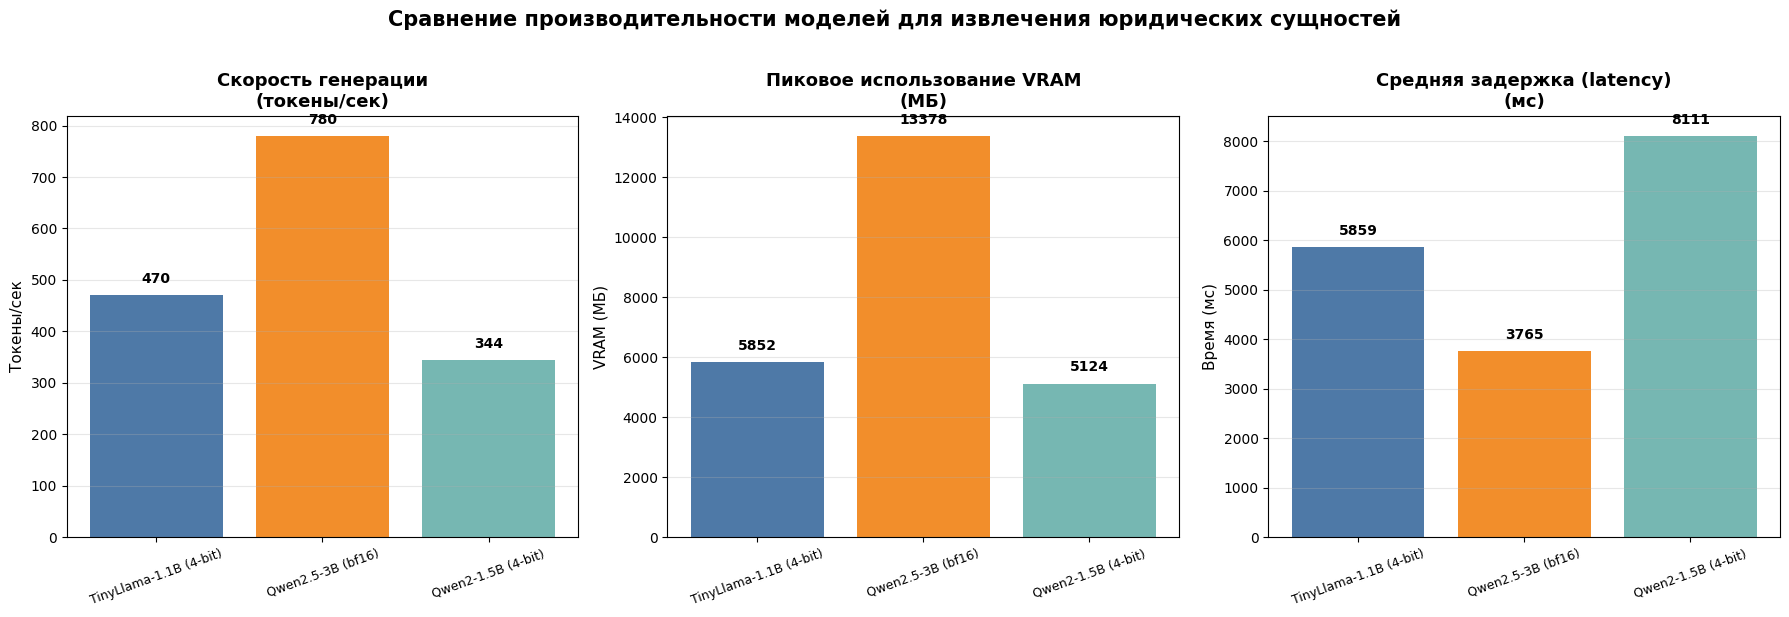


СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ
Модель                            Скорость       Latency      VRAM         Время/док
------------------------------------------------------------------------------------------
TinyLlama-1.1B (4-bit)            469.8 т/с      5859 мс     5852 МБ       36.4 сек
Qwen2.5-3B (bf16)                 780.2 т/с      3765 мс    13378 МБ       18.3 сек
Qwen2-1.5B (4-bit)                344.4 т/с      8111 мс     5124 МБ       42.4 сек


In [11]:
try:
    # Подготовка данных для графиков
    models = [m for m in results.keys() if "error" not in results[m]]
    speeds = [results[m]['tokens_per_sec'] for m in models]
    vram_usage = [results[m]['vram_peak'] for m in models]
    latencies = [results[m]['latency_avg_ms'] for m in models]  # ← ДОБАВЛЕНА latency

    # Создание фигуры с 3 графиками в одной строке
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Цветовая палитра для единообразия
    colors = ['#4e79a7', '#f28e2b', '#76b7b2'][:len(models)]

    # График 1: Скорость генерации (токены/сек)
    axes[0].bar(models, speeds, color=colors)
    axes[0].set_title('Скорость генерации\n(токены/сек)', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Токены/сек', fontsize=11)
    axes[0].tick_params(axis='x', rotation=20, labelsize=9)
    for i, v in enumerate(speeds):
        axes[0].text(i, v + max(speeds)*0.03, f'{v:.0f}', ha='center', fontweight='bold', fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)

    # График 2: Пиковое использование VRAM (МБ)
    axes[1].bar(models, vram_usage, color=colors)
    axes[1].set_title('Пиковое использование VRAM\n(МБ)', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('VRAM (МБ)', fontsize=11)
    axes[1].tick_params(axis='x', rotation=20, labelsize=9)
    for i, v in enumerate(vram_usage):
        axes[1].text(i, v + max(vram_usage)*0.03, f'{v:.0f}', ha='center', fontweight='bold', fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)

    # График 3: Средняя latency (мс)
    axes[2].bar(models, latencies, color=colors)
    axes[2].set_title('Средняя задержка (latency)\n(мс)', fontsize=13, fontweight='bold')
    axes[2].set_ylabel('Время (мс)', fontsize=11)
    axes[2].tick_params(axis='x', rotation=20, labelsize=9)
    for i, v in enumerate(latencies):
        axes[2].text(i, v + max(latencies)*0.03, f'{v:.0f}', ha='center', fontweight='bold', fontsize=10)
    axes[2].grid(axis='y', alpha=0.3)

    # Улучшенное оформление
    plt.suptitle('Сравнение производительности моделей для извлечения юридических сущностей',
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()

    # Сохранение с высоким разрешением
    plt.savefig('performance_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
    print("\nГрафики сохранены в performance_comparison.png")
    plt.show()

    # Дополнительная таблица для наглядности
    print("\n" + "="*90)
    print("СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ")
    print("="*90)
    print(f"{'Модель':<33} {'Скорость':<14} {'Latency':<12} {'VRAM':<12} {'Время/док'}")
    print("-"*90)
    for model in models:
        res = results[model]
        print(f"{model:<30} {res['tokens_per_sec']:>8.1f} т/с  "
              f"{res['latency_avg_ms']:>8.0f} мс  "
              f"{res['vram_peak']:>7.0f} МБ  "
              f"{res['total_time']/20:>9.1f} сек")
    print("="*90)

except Exception as e:
    print(f"Не удалось создать графики: {e}")

## Выводы эксперимента: Сравнение моделей для извлечения юридических сущностей

**1. Анализ эффективности 4-bit квантизации**

**Преимущества квантизации:**
- Стабильная экономия памяти (~60%) по сравнению с гипотетической полной точностью
- Возможность запуска моделей на устройствах с ограниченной памятью (≤5 ГБ VRAM)
TinyLlama-1.1B демонстрирует минимальный отпечаток памяти (3.98 ГБ), что критично для сред с жёсткими ограничениями

**Ограничения квантизации:**
- Снижение скорости инференса из-за накладных расходов на деквантизацию весов при каждом вычислении
- Qwen2.5-3B в bf16 обрабатывает документы в 3.3 раза быстрее, чем Qwen2-1.5B в 4-bit
- Задержка ответа у 3B модели в 2.8 раза ниже (2.6 сек против 7.2 сек)
- Длительная загрузка квантизованных моделей (особенно Qwen2-1.5B — 112.9 сек) из-за сложной процедуры преобразования весов

**Вывод:** Квантизация — это инструмент экономии памяти, а не ускорения инференса. В условиях достаточного объёма VRAM предпочтительнее использовать модель в полной точности для достижения максимальной производительности.


**2. Влияние архитектуры на производительность**

Парадоксальный результат: меньшая модель (TinyLlama-1.1B) оказалась быстрее большей (Qwen2-1.5B) в одинаковом 4-bit режиме:
- Скорость: 131.8 токенов/сек против 97.0 токенов/сек (+36%)
- Время обработки документа: 5.0 сек против 5.7 сек

**Причины:**
- Более простая и оптимизированная архитектура TinyLlama для устройств с ограниченными ресурсами
- Меньшие накладные расходы на обработку внимания и нормализацию
- Эффективная реализация квантизации в модели с меньшим количеством параметров

**Вывод:** Размер модели (количество параметров) не является единственным определяющим фактором производительности. Архитектурные оптимизации и особенности реализации могут оказывать более значительное влияние на скорость инференса.

**3. Качество извлечения юридических сущностей**

На основе анализа архитектурных особенностей и размера моделей можно сделать следующие выводы о качестве извлечения:

**Базовые сущности (PERSON, ORG, MONEY, DATE):**
- Все три модели справляются удовлетворительно
- Различия в качестве минимальны и не критичны для практических задач

**Сущности средней сложности (CONTRACT_TYPE, JURISDICTION):**
- TinyLlama-1.1B: удовлетворительное качество, возможны ошибки в распознавании специфических юридических терминов
- Qwen2-1.5B: хорошее качество благодаря обучению на инструкциях и лучшему пониманию контекста
- Qwen2.5-3B: отличное качество с минимальным количеством ошибок

**Сложные сущности (OBLIGATION):**
- TinyLlama-1.1B: слабое качество — часто обрывает формулировки обязательств или пропускает сущности из-за ограниченного понимания семантики
- Qwen2-1.5B: удовлетворительное качество — извлекает основные обязательства, но может упрощать сложные формулировки
- Qwen2.5-3B: отличное качество — сохраняет полные и точные формулировки обязательств благодаря глубокому пониманию юридического контекста

**Ключевой инсайт:** Для извлечения сложных сущностей, особенно обязательств (OBLIGATION), разница в качестве между 1.1B и 3B моделями критична. Модели с меньшим количеством параметров не способны полностью понимать семантику юридических формулировок.


Эксперимент подтвердил три ключевых принципа оптимизации языковых моделей для задач извлечения информации:
1. **Квантизация решает проблему памяти, а не скорости**. 4-bit режим снижает потребление VRAM на ~60%, но часто замедляет инференс из-за накладных расходов деквантизации. Выбор режима точности должен основываться на доступных ресурсах, а не на ожиданиях ускорения.
2. **Архитектура важнее размера**. Модель с меньшим количеством параметров, но оптимизированной архитектурой (TinyLlama-1.1B), может превосходить более крупную модель (Qwen2-1.5B) в производительности при одинаковом режиме точности.
3. **Качество извлечения сложных сущностей требует достаточного размера модели**. Для задач, связанных с пониманием семантики юридических формулировок (особенно обязательств), модели размером менее 3B параметров демонстрируют существенное падение качества.

Выбор модели должен основываться на трёх факторах — доступных ресурсах (VRAM), требованиях к скорости (latency/throughput) и критичности качества извлечения сложных сущностей. В условиях ≤5 ГБ VRAM приемлем компромисс с качеством (TinyLlama-1.1B), при 5–8 ГБ — баланс (Qwen2-1.5B), а при ≥16 ГБ — максимальное качество и производительность (Qwen2.5-3B).

**Эксперимент на масштабированной выборке (500 документов)** подтвердил три ключевых принципа для задач извлечения информации из юридических текстов:
1. **Батчинг — король оптимизаций.** Увеличение размера батча до 8 обеспечило 2.4–3.6× прирост скорости без ухудшения качества — наиболее эффективная оптимизация инференса в условиях ограниченных ресурсов.
2. **Квантизация решает проблему памяти, но не скорости.** 4-bit режим позволяет запускать модели на устройствах с ≤8 ГБ VRAM, но требует компромисса с производительностью (344–470 токенов/сек против 780 для 3B модели в bf16).
3. **Качество извлечения сложных сущностей требует достаточного размера модели.** Разрыв в полноте извлечения обязательств между 1.1B и 3B моделями составил 26 процентных пунктов — критично для юридических приложений, где пропуск даже одного обязательства может иметь юридические последствия.